In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from collections import Counter
import math
import optuna
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("data.csv")

In [3]:
print(df.head())

   Age Sex      BP Cholesterol  Na_to_K   Drug
0   23   F    HIGH        HIGH   25.355  DrugY
1   47   M     LOW        HIGH   13.093  drugC
2   47   M     LOW        HIGH   10.114  drugC
3   28   F  NORMAL        HIGH    7.798  drugX
4   61   F     LOW        HIGH   18.043  DrugY


In [4]:
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')
df['Sex'] = pd.factorize(df['Sex'])[0]
df['BP'] = pd.factorize(df['BP'])[0]
df['Cholesterol'] = pd.factorize(df['Cholesterol'])[0]
df['Na_to_K'] = pd.factorize(df['Na_to_K'])[0]
df['Drug'] = pd.factorize(df['Drug'])[0]

In [5]:
scaler = MinMaxScaler()
columns_to_normalize = df.columns[df.columns != 'Drug']
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

In [6]:
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,0.135593,0.0,0.0,0.0,0.000000,0
1,0.542373,1.0,0.5,0.0,0.005076,1
2,0.542373,1.0,0.5,0.0,0.010152,1
3,0.220339,0.0,1.0,0.0,0.015228,2
4,0.779661,0.0,0.5,0.0,0.020305,0


In [7]:
X = df[['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K']]
y = df['Drug']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.4)

In [9]:
print(X_train[:10])

          Age  Sex   BP  Cholesterol   Na_to_K
36   0.288136  1.0  0.0          1.0  0.182741
140  0.576271  1.0  0.0          1.0  0.710660
18   0.135593  1.0  0.5          0.0  0.091371
118  0.288136  0.0  0.0          1.0  0.598985
82   0.288136  0.0  0.5          0.0  0.416244
81   0.830508  1.0  1.0          0.0  0.411168
59   0.322034  1.0  0.0          0.0  0.299492
170  0.220339  0.0  1.0          0.0  0.857868
180  0.118644  0.0  0.0          1.0  0.908629
116  0.881356  1.0  1.0          1.0  0.588832


## Sklearn

In [10]:
#optuna.logging.disable_default_handler()

In [11]:
def neighbors_and_p_params(trial):
    n = trial.suggest_int('n_neighbors', 3, 25)
    p = trial.suggest_int('p', 1, 10)
    knn = KNeighborsClassifier(n_neighbors=n, p=p)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    return accuracy_score(y_test, y_pred)

def neighbors_param(trial):
    n = trial.suggest_int('n_neighbors', low=1, high=10, step=1)
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    return accuracy_score(y_test, y_pred)

def p_param(trial):
    p = trial.suggest_int('p', 1, 25)
    knn = KNeighborsClassifier(p=p)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    return accuracy_score(y_test, y_pred)

def print_best(tr):
    print("Best params:")
    for key, value in tr.params.items():
        print(key, '=', value)
    print('Best accuracy=', tr.value)


## Кол-во соседей и расстояние

In [12]:
study = optuna.create_study(direction='maximize')

study.optimize(neighbors_and_p_params, n_trials=100)

tr = study.best_trial
print_best(tr)


[I 2024-04-04 15:17:36,681] A new study created in memory with name: no-name-4d63e59a-2d7d-43b6-a35e-cbfdfa4c78f1
[I 2024-04-04 15:17:36,699] Trial 0 finished with value: 0.475 and parameters: {'n_neighbors': 5, 'p': 3}. Best is trial 0 with value: 0.475.
[I 2024-04-04 15:17:36,711] Trial 1 finished with value: 0.44166666666666665 and parameters: {'n_neighbors': 16, 'p': 6}. Best is trial 0 with value: 0.475.
[I 2024-04-04 15:17:36,721] Trial 2 finished with value: 0.43333333333333335 and parameters: {'n_neighbors': 6, 'p': 6}. Best is trial 0 with value: 0.475.
[I 2024-04-04 15:17:36,733] Trial 3 finished with value: 0.4583333333333333 and parameters: {'n_neighbors': 25, 'p': 4}. Best is trial 0 with value: 0.475.
[I 2024-04-04 15:17:36,745] Trial 4 finished with value: 0.4666666666666667 and parameters: {'n_neighbors': 15, 'p': 10}. Best is trial 0 with value: 0.475.
[I 2024-04-04 15:17:36,756] Trial 5 finished with value: 0.39166666666666666 and parameters: {'n_neighbors': 13, 'p': 

Best params:
n_neighbors = 20
p = 2
Best accuracy= 0.49166666666666664


## Количество соседей

[I 2024-04-04 15:17:38,673] A new study created in memory with name: no-name-672d073c-1158-455d-aaf4-cbd0da175614
[I 2024-04-04 15:17:38,687] Trial 0 finished with value: 0.4083333333333333 and parameters: {'n_neighbors': 3}. Best is trial 0 with value: 0.4083333333333333.
[I 2024-04-04 15:17:38,696] Trial 1 finished with value: 0.45 and parameters: {'n_neighbors': 1}. Best is trial 1 with value: 0.45.
[I 2024-04-04 15:17:38,707] Trial 2 finished with value: 0.43333333333333335 and parameters: {'n_neighbors': 8}. Best is trial 1 with value: 0.45.
[I 2024-04-04 15:17:38,717] Trial 3 finished with value: 0.4083333333333333 and parameters: {'n_neighbors': 3}. Best is trial 1 with value: 0.45.
[I 2024-04-04 15:17:38,727] Trial 4 finished with value: 0.43333333333333335 and parameters: {'n_neighbors': 8}. Best is trial 1 with value: 0.45.
[I 2024-04-04 15:17:38,736] Trial 5 finished with value: 0.43333333333333335 and parameters: {'n_neighbors': 6}. Best is trial 1 with value: 0.45.
[I 2024

Best params:
n_neighbors = 5
Best accuracy= 0.4666666666666667


Text(0, 0.5, 'accuracy')

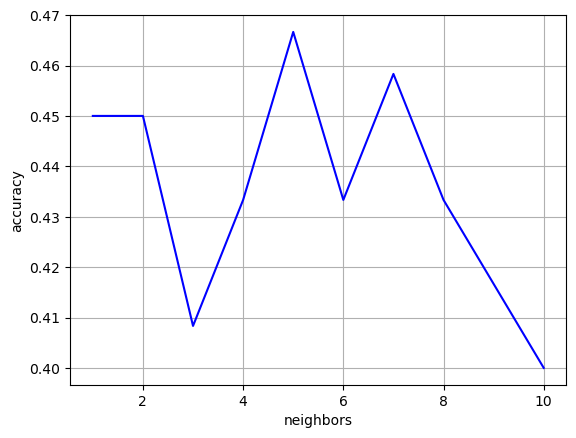

In [13]:
study = optuna.create_study(direction='maximize')
study.optimize(neighbors_param, n_trials=100)
tr = study.best_trial
print_best(tr)

x_values = [trial.params['n_neighbors'] for trial in study.get_trials()]
y_values = [trial.value for trial in study.get_trials()]

mp = dict()

for i in range(len(x_values)):
    key = x_values[i]
    value = y_values[i]
    if key not in mp:
        mp[key] = value
    else:
        mp[key] = max(mp[key], value)

sorted_dict = dict(sorted(mp.items()))
x = list(sorted_dict.keys())
y = list(sorted_dict.values())

plt.plot(x, y, color='blue')
plt.grid(True)
plt.xlabel('neighbors')
plt.ylabel('accuracy')

## Расстояние

[I 2024-04-04 15:17:40,284] A new study created in memory with name: no-name-f16c2923-dd2a-4faa-bddc-f0017fd2df79
[I 2024-04-04 15:17:40,297] Trial 0 finished with value: 0.44166666666666665 and parameters: {'p': 11}. Best is trial 0 with value: 0.44166666666666665.
[I 2024-04-04 15:17:40,307] Trial 1 finished with value: 0.475 and parameters: {'p': 4}. Best is trial 1 with value: 0.475.
[I 2024-04-04 15:17:40,318] Trial 2 finished with value: 0.4666666666666667 and parameters: {'p': 5}. Best is trial 1 with value: 0.475.
[I 2024-04-04 15:17:40,328] Trial 3 finished with value: 0.44166666666666665 and parameters: {'p': 13}. Best is trial 1 with value: 0.475.
[I 2024-04-04 15:17:40,338] Trial 4 finished with value: 0.4666666666666667 and parameters: {'p': 2}. Best is trial 1 with value: 0.475.
[I 2024-04-04 15:17:40,348] Trial 5 finished with value: 0.475 and parameters: {'p': 3}. Best is trial 1 with value: 0.475.
[I 2024-04-04 15:17:40,358] Trial 6 finished with value: 0.425 and param

Best params:
p = 4
Best accuracy= 0.475


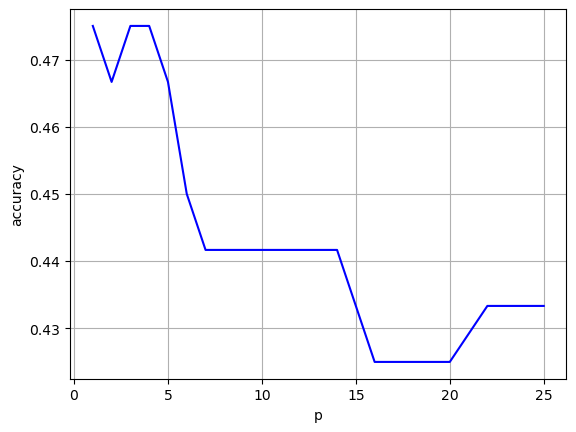

In [14]:
study = optuna.create_study(direction='maximize')
study.optimize(p_param, n_trials=100)
tr = study.best_trial
print_best(tr)

x_values = [trial.params['p'] for trial in study.get_trials()]
y_values = [trial.value for trial in study.get_trials()]


mp = dict()

mp = dict()

for i in range(len(x_values)):
    key = x_values[i]
    value = y_values[i]
    if key not in mp:
        mp[key] = value
    else:
        mp[key] = max(mp[key], value)

sorted_dict = dict(sorted(mp.items()))
x = list(sorted_dict.keys())
y = list(sorted_dict.values())

plt.plot(x, y, color='blue')
plt.grid(True)
plt.xlabel('p')
plt.ylabel('accuracy')
plt.show()

## My knn

## Metrics

In [15]:
def minkowski(a, b, p):
    sm = 0
    for i in range(len(a)):
        sm = sm + (abs(a[i] - b[i]) ** p)
    return sm ** p

def cos_similarity(a, b):
    pr = np.dot(a, b)
    a1 = np.linalg.norm(a)
    b1 = np.linalg.norm(b)
    return pr / a1 * b1


In [16]:
def manhattan(a, b):
    return minkowski(a, b, 1)

def evk(a, b):
    return minkowski(a, b, 2)

def cos_dist(a, b):
    return 1 - cos_similarity(a, b)

metrics = [manhattan, evk, cos_dist]

# Kernels

In [17]:
def uniform(u):
    t = 1 if u < 1 else 0
    return t * 0.5

def epan(u):
    t = 1 if u < 1 else 0
    return 3 / 4 * (1 - u**2) * t

def triang(u):
    t = 1 if u < 1 else 0
    return (1 - abs(u)) * t

def gaussian(u):
    return 1 / math.sqrt(2 * 3.14) * math.exp(-(u**2) / 2)

kernels = [uniform, epan, triang, gaussian]

In [18]:
arr = []
for _, row in df.iterrows():
    val = []
    for _, v in row.items():
            val.append(v)
    arr.append((val[:-1], val[-1]))

## Train and test

In [19]:
p = int(len(arr) * 0.4)
train = arr[:p]
test = arr[p:]

train_x = [el[0] for el in arr][:p]
train_y = [el[1] for el in arr][:p]

test_x = [el[0] for el in arr][p:]
test_y = [el[1] for el in arr][p:]



In [20]:
class MyKnn:

    def __init__(self, train, kernel, metric, n, h=None, w=None):
        self.train_x = [el[0] for el in train][:p]
        self.train_y = [el[1] for el in train][:p]
        self.kernel = kernel
        self.metric = metric
        self.h = h
        self.w = w
        self.n = n

    def predict(self, test):
        res = []
        for i in range(len(test)):
            cur = test[i]
            if self.h == None:
                res.append(self.window(cur))
            else:
                res.append(self.const_window(cur, self.h))
        return res


    def const_window(self, cur, h):
        dst = []
        for i in range(len(self.train_x)):
            x = 1 if self.w == None else self.w[i]
            t = x * self.kernel(self.metric(cur, self.train_x[i]) / h)
            dst.append((self.train_y[i], t))
        s = sorted(dst, key=lambda x: x[1])
        f = [pair[0] for pair in s]
        c = Counter(f[:self.n])
        return c.most_common(1)[0][0]

    def window(self, cur):
        dst = []
        for i in range(len(self.train_x)):
            el = self.train_x[i] #data[i]
            t = self.metric(cur, el)
            dst.append((self.train_y[i], t))
        s = sorted(dst, key=lambda x: x[1])
        h = s[self.n+1][1]
        return self.const_window(cur, h)


In [21]:
exp = [p[1] for p in test]


model = MyKnn(train, kernel=triang, metric=evk, n=10, h=1)
res = model.predict(test_x)
print(accuracy_score(res, exp))


0.425


In [22]:
def all_params(trial):
    n = trial.suggest_int('neighbors', 3, 10)
    h = trial.suggest_int('h', 1, 100)
    model = MyKnn(train, kernel=triang, metric=evk, n=n, h=h)
    res = model.predict(test_x)
    return accuracy_score(res, exp)

def my_h(trial):
    h = trial.suggest_int('h', 1, 100)
    model = MyKnn(train, kernel=triang, metric=evk, n = 10, h = h)
    res = model.predict(test_x)
    return accuracy_score(res, exp)

def my_n(trial):
    n = trial.suggest_int('neighbors', 3, 10)
    model = MyKnn(train, h=10, n=n, kernel=triang, metric=evk)
    res = model.predict(test_x)
    return accuracy_score(res, exp)


## Соседи и расстояние

In [23]:
study = optuna.create_study(direction='maximize')
study.optimize(all_params, n_trials=100)

tr = study.best_trial
print_best(tr)

[I 2024-04-04 15:17:41,993] A new study created in memory with name: no-name-018e6ab5-ec28-4b61-b3da-ce4222555128
[I 2024-04-04 15:17:42,015] Trial 0 finished with value: 0.3 and parameters: {'neighbors': 8, 'h': 12}. Best is trial 0 with value: 0.3.
[I 2024-04-04 15:17:42,035] Trial 1 finished with value: 0.30833333333333335 and parameters: {'neighbors': 10, 'h': 66}. Best is trial 1 with value: 0.30833333333333335.
[I 2024-04-04 15:17:42,054] Trial 2 finished with value: 0.24166666666666667 and parameters: {'neighbors': 5, 'h': 34}. Best is trial 1 with value: 0.30833333333333335.
[I 2024-04-04 15:17:42,086] Trial 3 finished with value: 0.24166666666666667 and parameters: {'neighbors': 5, 'h': 84}. Best is trial 1 with value: 0.30833333333333335.
[I 2024-04-04 15:17:42,106] Trial 4 finished with value: 0.24166666666666667 and parameters: {'neighbors': 5, 'h': 42}. Best is trial 1 with value: 0.30833333333333335.
[I 2024-04-04 15:17:42,128] Trial 5 finished with value: 0.3083333333333

Best params:
neighbors = 9
h = 1
Best accuracy= 0.43333333333333335


## Расстояние

[I 2024-04-04 15:17:44,861] A new study created in memory with name: no-name-10e13c1f-cc4b-40cc-9d63-e11d8bbf1b7e
[I 2024-04-04 15:17:44,889] Trial 0 finished with value: 0.30833333333333335 and parameters: {'h': 45}. Best is trial 0 with value: 0.30833333333333335.
[I 2024-04-04 15:17:44,908] Trial 1 finished with value: 0.30833333333333335 and parameters: {'h': 28}. Best is trial 0 with value: 0.30833333333333335.
[I 2024-04-04 15:17:44,927] Trial 2 finished with value: 0.30833333333333335 and parameters: {'h': 59}. Best is trial 0 with value: 0.30833333333333335.
[I 2024-04-04 15:17:44,946] Trial 3 finished with value: 0.30833333333333335 and parameters: {'h': 42}. Best is trial 0 with value: 0.30833333333333335.
[I 2024-04-04 15:17:44,965] Trial 4 finished with value: 0.30833333333333335 and parameters: {'h': 25}. Best is trial 0 with value: 0.30833333333333335.
[I 2024-04-04 15:17:44,983] Trial 5 finished with value: 0.30833333333333335 and parameters: {'h': 61}. Best is trial 0 w

Best params:
h = 1
Best accuracy= 0.425


Text(0, 0.5, 'accuracy')

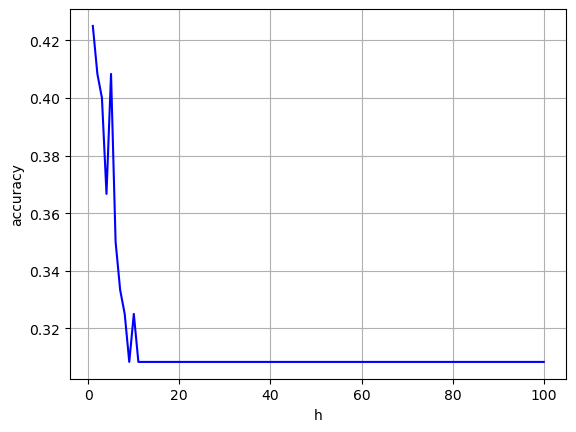

In [24]:
study = optuna.create_study(direction='maximize')
study.optimize(my_h, n_trials=100)
tr = study.best_trial
print_best(tr)

x_values = [trial.params['h'] for trial in study.get_trials()]
y_values = [trial.value for trial in study.get_trials()]

mp = dict()
for i in range(len(x_values)):
    key = x_values[i]
    value = y_values[i]
    if key not in mp:
        mp[key] = value
    else:
        mp[key] = max(mp[key], value)

sorted_dict = dict(sorted(mp.items()))
x = list(sorted_dict.keys())
y = list(sorted_dict.values())

plt.plot(x, y, color='blue')
plt.grid(True)
plt.xlabel('h')
plt.ylabel('accuracy')



## Соседи

[I 2024-04-04 15:17:47,458] A new study created in memory with name: no-name-88d3abed-ce86-47c8-9b30-517a034f92d4
[I 2024-04-04 15:17:47,479] Trial 0 finished with value: 0.31666666666666665 and parameters: {'neighbors': 9}. Best is trial 0 with value: 0.31666666666666665.
[I 2024-04-04 15:17:47,498] Trial 1 finished with value: 0.2833333333333333 and parameters: {'neighbors': 8}. Best is trial 0 with value: 0.31666666666666665.
[I 2024-04-04 15:17:47,520] Trial 2 finished with value: 0.2916666666666667 and parameters: {'neighbors': 4}. Best is trial 0 with value: 0.31666666666666665.
[I 2024-04-04 15:17:47,538] Trial 3 finished with value: 0.2833333333333333 and parameters: {'neighbors': 6}. Best is trial 0 with value: 0.31666666666666665.
[I 2024-04-04 15:17:47,557] Trial 4 finished with value: 0.2833333333333333 and parameters: {'neighbors': 8}. Best is trial 0 with value: 0.31666666666666665.
[I 2024-04-04 15:17:47,574] Trial 5 finished with value: 0.2833333333333333 and parameters

Best params:
neighbors = 10
Best accuracy= 0.325


Text(0.5, 0, 'neighbors')

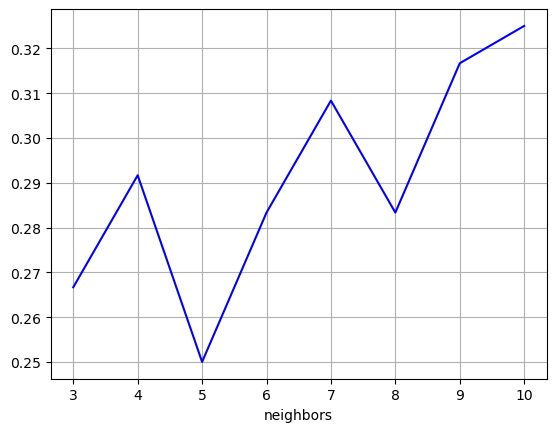

In [25]:
study = optuna.create_study(direction='maximize')
study.optimize(my_n, n_trials=100)
tr = study.best_trial
print_best(tr)

x_values = [trial.params['neighbors'] for trial in study.get_trials()]
y_values = [trial.value for trial in study.get_trials()]

mp = dict()
for i in range(len(x_values)):
    key = x_values[i]
    value = y_values[i]
    if key not in mp:
        mp[key] = value
    else:
        mp[key] = max(mp[key], value)

sorted_dict = dict(sorted(mp.items()))
x = list(sorted_dict.keys())
y = list(sorted_dict.values())

plt.plot(x, y, color='blue')
plt.grid(True)
plt.xlabel('neighbors')

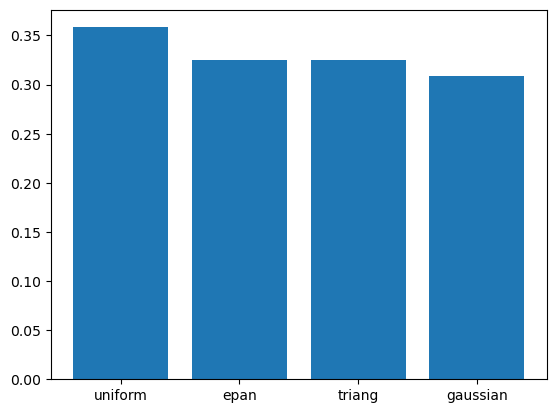

Best kernel= <function uniform at 0x000001D65D2E09A0>


In [26]:
mp = dict()
best_kernel = None 
best_acc = -1
for kernel in kernels:
    model = MyKnn(train=train, h=10, n=10, kernel=kernel, metric=evk)
    res = model.predict(test_x)
    acc = accuracy_score(res, exp)
    mp[kernel.__name__] = acc
    if acc > best_acc:
        best_kernel = kernel
        best_acc = acc

x_values = list(mp.keys())    
y_values = list(mp.values())

plt.bar(x_values, y_values)
plt.show()
print("Best kernel=", best_kernel)

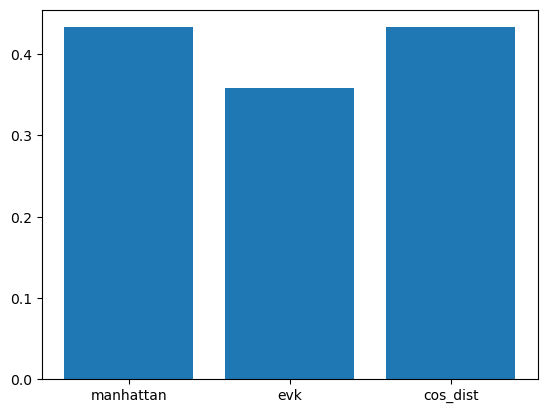

Best metric= <function manhattan at 0x000001D65D2AB920>


In [27]:
mp = dict()
best_metric = None
best_acc = 0
for metr in metrics:
   model = MyKnn(train=train, h=10, n=10, kernel=uniform, metric=metr) 
   res = model.predict(test_x)
   acc = accuracy_score(res, exp)
   mp[metr.__name__] = acc
   if acc > best_acc:
      best_metric = metr
      best_acc = acc
      

x_values = list(mp.keys())
y_values = list(mp.values())
plt.bar(x_values, y_values)
plt.show()
print("Best metric=", best_metric)

In [30]:
def my_lowess(train, kernel):
    w = [1] * len(train)
    for i in range(len(train)):
        train_copy = train.copy()
        del train_copy[i]
        model = MyKnn(train_copy, kernel=best_kernel, metric=best_metric, n=3, h=8)
        res = model.predict([train[i][0]])[0]
        tmp = kernel(res - train[0][1])
        w[i] = tmp 
    return w

w = my_lowess(train, gaussian)
print(w[:20])
model = MyKnn(train, kernel=uniform, metric=evk, n=22, w=None)
res = model.predict(test_x)
print('Result =', accuracy_score(exp, res))


[0.24203208227207357, 0.3990434422338111, 0.3990434422338111, 0.24203208227207357, 0.24203208227207357, 0.24203208227207357, 0.24203208227207357, 0.24203208227207357, 0.24203208227207357, 0.24203208227207357, 0.24203208227207357, 0.24203208227207357, 0.24203208227207357, 0.24203208227207357, 0.24203208227207357, 0.24203208227207357, 0.24203208227207357, 0.24203208227207357, 0.24203208227207357, 0.24203208227207357]
Result = 0.43333333333333335


In [29]:
knn = KNeighborsClassifier(n_neighbors=3, p=8, weights='distance')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
res1 = accuracy_score(y_test, y_pred)
print('Result =',res1)

Result = 0.44166666666666665
